<a href="https://colab.research.google.com/github/Tam107/BDM/blob/main/Main_EE_%2B_RF_%2B_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from IPython.display import Image

print("Libraries imported successfully")

Libraries imported successfully


Cell 2: Load and Select Columns

In [2]:
cols_to_keep = [
    'price', 'brand', 'model', 'gearbox', 'kilometer', 'powerPS',
    'yearOfRegistration', 'monthOfRegistration', 'dateCreated',
    'vehicleType', 'fuelType', 'notRepairedDamage'
]
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)
print("5 dòng đầu tiên của dataset:")
print(data.head())
print("\nThông tin dataset:")
print(data.info())

5 dòng đầu tiên của dataset:
   price vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480         NaN                1993    manuell        0   golf   
1  18300       coupe                2011    manuell      190    NaN   
2   9800         suv                2004  automatik      163  grand   
3   1500  kleinwagen                2001    manuell       75   golf   
4   3600  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  
0  2016-03-24 00:00:00  
1  2016-03-24 00:00:00  
2  2016-03-1

Cell 3: Data Preprocessing

In [3]:
# Handle missing values
data['powerPS'] = data['powerPS'].replace(0, np.nan).fillna(data['powerPS'].median())
data['yearOfRegistration'] = data['yearOfRegistration'].replace(0, np.nan).fillna(data['yearOfRegistration'].median())
data['monthOfRegistration'] = data['monthOfRegistration'].replace(0, np.nan).fillna(data['monthOfRegistration'].median())
data['gearbox'] = data['gearbox'].fillna('manual')
data['model'] = data['model'].fillna('unknown')
data['brand'] = data['brand'].fillna('unknown')
data['vehicleType'] = data['vehicleType'].fillna('unknown')
data['fuelType'] = data['fuelType'].fillna('unknown')
data['notRepairedDamage'] = data['notRepairedDamage'].fillna('nein')

# Feature engineering
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data['car_age'] = data['adYear'] - data['yearOfRegistration']
data['powerPS_per_km'] = data['powerPS'] / (data['kilometer'] + 1)
data['age_km_interaction'] = data['car_age'] * data['kilometer']
data['is_damaged'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0})
data = data.drop(columns=['dateCreated', 'yearOfRegistration', 'notRepairedDamage'])

# Ensure categorical columns are strings
for col in ['brand', 'model', 'gearbox', 'vehicleType', 'fuelType']:
    data[col] = data[col].astype(str)

# Dummies for gearbox
gearbox_dummies = pd.get_dummies(data['gearbox'], prefix='gearbox')
data = pd.concat([data, gearbox_dummies], axis=1).drop('gearbox', axis=1)

# Numeric columns
numeric_cols = [col for col in data.columns if col not in ['price', 'brand', 'model', 'vehicleType', 'fuelType']]

# Filter price > 0
data = data[data['price'] > 0]
print(f"Number of rows after removing price=0: {len(data)}")

# Clip outliers
for col in ['price', 'kilometer', 'powerPS', 'car_age']:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    print(f"Clipping {col}: lower_bound={lower_bound}, upper_bound={upper_bound}")
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Scale numeric features
scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Scale price
price_scaler = MinMaxScaler()
data['price'] = price_scaler.fit_transform(data[['price']])
print("Price Scaler Parameters:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

print("\n5 dòng đầu tiên sau khi xử lý:")
print(data.head())
print("\nThông tin dataset sau xử lý:")
print(data.info())

Number of rows after removing price=0: 360750
Clipping price: lower_bound=110.0, upper_bound=36500.0
Clipping kilometer: lower_bound=5000.0, upper_bound=150000.0
Clipping powerPS: lower_bound=45.0, upper_bound=340.0
Clipping car_age: lower_bound=-2.0, upper_bound=37.0
Price Scaler Parameters:
data_min_: [110.]
data_max_: [36500.]

5 dòng đầu tiên sau khi xử lý:
      price vehicleType   powerPS    model  kilometer  monthOfRegistration  \
0  0.010168     unknown  0.203390     golf   1.000000             0.454545   
1  0.499863       coupe  0.491525  unknown   0.827586             0.363636   
2  0.266282         suv  0.400000    grand   0.827586             0.636364   
3  0.038197  kleinwagen  0.101695     golf   1.000000             0.454545   
4  0.095905  kleinwagen  0.081356    fabia   0.586207             0.545455   

  fuelType       brand  adYear   car_age  powerPS_per_km  age_km_interaction  \
0   benzin  volkswagen     1.0  0.641026        0.000199            0.406100   
1   die

Cell 4: Train-Test Split

In [4]:
X = data.drop(['price'], axis=1).copy()
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f'\nTập huấn luyện có {X_train_new.shape[0]} bản ghi và {X_train_new.shape[1]} cột.')
print(f'Tập validation có {len(X_val)} bản ghi.')
print(f'Tập kiểm tra có {len(X_test)} bản ghi.')


Tập huấn luyện có 230880 bản ghi và 15 cột.
Tập validation có 57720 bản ghi.
Tập kiểm tra có 72150 bản ghi.


Cell 5: Encode Categorical Variables for Embedding (MLP)

In [5]:
input_list_train_new = []
input_list_val = []
input_list_test = []
cat_encoders = {}
for col in ['brand', 'model', 'vehicleType', 'fuelType']:
    unique_cat = np.unique(X_train_new[col])
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_cat)}
    input_list_train_new.append(X_train_new[col].map(cat_encoders[col]).values.astype(np.int32))
    input_list_val.append(X_val[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    input_list_test.append(X_test[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    print(f'\nCó {len(unique_cat)} giá trị duy nhất trong cột {col} trong tập huấn luyện.')

numeric_cols = [col for col in X_train_new.columns if col not in ['brand', 'model', 'vehicleType', 'fuelType']]
input_list_train_new.append(X_train_new[numeric_cols].values.astype(np.float32))
input_list_val.append(X_val[numeric_cols].values.astype(np.float32))
input_list_test.append(X_test[numeric_cols].values.astype(np.float32))

y_train_new = y_train_new.values.astype(np.float32)
y_val = y_val.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)


Có 40 giá trị duy nhất trong cột brand trong tập huấn luyện.

Có 250 giá trị duy nhất trong cột model trong tập huấn luyện.

Có 9 giá trị duy nhất trong cột vehicleType trong tập huấn luyện.

Có 8 giá trị duy nhất trong cột fuelType trong tập huấn luyện.


Cell 6: Prepare Data for Random Forest

In [6]:
X_train_rf = X_train_new.copy()
X_val_rf = X_val.copy()
X_test_rf = X_test.copy()

# One-hot encode categorical variables
cat_cols = ['brand', 'model', 'vehicleType', 'fuelType']
X_train_rf = pd.get_dummies(X_train_rf, columns=cat_cols)
X_val_rf = pd.get_dummies(X_val_rf, columns=cat_cols)
X_test_rf = pd.get_dummies(X_test_rf, columns=cat_cols)

# Align columns across train, validation, and test sets
X_train_rf, X_val_rf = X_train_rf.align(X_val_rf, join='left', axis=1, fill_value=0)
X_train_rf, X_test_rf = X_train_rf.align(X_test_rf, join='left', axis=1, fill_value=0)
X_val_rf, X_test_rf = X_val_rf.align(X_test_rf, join='left', axis=1, fill_value=0)

print(f"Random Forest training data shape: {X_train_rf.shape}")
print(f"Random Forest validation data shape: {X_val_rf.shape}")
print(f"Random Forest test data shape: {X_test_rf.shape}")

Random Forest training data shape: (230880, 318)
Random Forest validation data shape: (57720, 318)
Random Forest test data shape: (72150, 318)


Cell 7: Train Random Forest and Generate Predictions

In [7]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_rf, y_train_new)

# Generate RF predictions
rf_train_preds = rf.predict(X_train_rf).astype(np.float32)
rf_val_preds = rf.predict(X_val_rf).astype(np.float32)
rf_test_preds = rf.predict(X_test_rf).astype(np.float32)

Cell 8: Define and Train MLP Model (Standalone)

In [9]:
n_unique_brand = len(np.unique(X_train_new['brand']))
n_unique_model = len(np.unique(X_train_new['model']))
n_unique_vehicleType = len(np.unique(X_train_new['vehicleType']))
n_unique_fuelType = len(np.unique(X_train_new['fuelType']))  # Fixed typo here

input_brand = Input(shape=(1,), name='input_brand_mlp')
emb_brand = Embedding(input_dim=n_unique_brand, output_dim=8)(input_brand)
emb_brand = Reshape(target_shape=(8,))(emb_brand)

input_model = Input(shape=(1,), name='input_model_mlp')
emb_model = Embedding(input_dim=n_unique_model, output_dim=15)(input_model)
emb_model = Reshape(target_shape=(15,))(emb_model)

input_vehicleType = Input(shape=(1,), name='input_vehicleType_mlp')
emb_vehicleType = Embedding(input_dim=n_unique_vehicleType, output_dim=5)(input_vehicleType)
emb_vehicleType = Reshape(target_shape=(5,))(emb_vehicleType)

input_fuelType = Input(shape=(1,), name='input_fuelType_mlp')
emb_fuelType = Embedding(input_dim=n_unique_fuelType, output_dim=4)(input_fuelType)
emb_fuelType = Reshape(target_shape=(4,))(emb_fuelType)

input_numeric = Input(shape=(len(numeric_cols),), name='input_numeric_mlp')
emb_numeric = input_numeric

input_data_mlp = [input_brand, input_model, input_vehicleType, input_fuelType, input_numeric]
emb_data_mlp = [emb_brand, emb_model, emb_vehicleType, emb_fuelType, emb_numeric]

model_data_mlp = Concatenate()(emb_data_mlp)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(model_data_mlp)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.005))(x)
outputs_mlp = Dense(1, activation='sigmoid')(x)

mlp = Model(inputs=input_data_mlp, outputs=outputs_mlp, name='MLP')
mlp.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.002), metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-05)

history_mlp = mlp.fit(
    input_list_train_new,
    y_train_new,
    validation_data=(input_list_val, y_val),
    epochs=150,
    batch_size=512,
    verbose=1,
    callbacks=[es, lr_scheduler]
)



Epoch 1/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.4245 - mae: 0.0799 - val_loss: 0.0354 - val_mae: 0.1267 - learning_rate: 0.0020
Epoch 2/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0105 - mae: 0.0532 - val_loss: 0.0126 - val_mae: 0.0623 - learning_rate: 0.0020
Epoch 3/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0092 - mae: 0.0499 - val_loss: 0.0097 - val_mae: 0.0535 - learning_rate: 0.0020
Epoch 4/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0090 - mae: 0.0502 - val_loss: 0.0102 - val_mae: 0.0551 - learning_rate: 0.0020
Epoch 5/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0090 - mae: 0.0504 - val_loss: 0.0103 - val_mae: 0.0513 - learning_rate: 0.0020
Epoch 6/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0089 - mae: 0.0503 - val_loss: 0.0105 - val_mae: 0.0565 - learning_rate: 0.0020
Epoch 7/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0088 - mae: 0.0502 - val_loss: 0.0098 - val_mae: 0.0548 - learning_rat

Cell 9: Define and Train EE+RF+MLP Model

Epoch 1/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.3856 - mae: 0.0586 - val_loss: 0.0384 - val_mae: 0.1547 - learning_rate: 0.0020
Epoch 2/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0051 - mae: 0.0376 - val_loss: 0.0092 - val_mae: 0.0562 - learning_rate: 0.0020
Epoch 3/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0041 - mae: 0.0355 - val_loss: 0.0061 - val_mae: 0.0420 - learning_rate: 0.0020
Epoch 4/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0040 - mae: 0.0353 - val_loss: 0.0057 - val_mae: 0.0415 - learning_rate: 0.0020
Epoch 5/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0039 - mae: 0.0348 - val_loss: 0.0061 - val_mae: 0.0433 - learning_rate: 0.0020
Epoch 6/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0040 - mae: 0.0351 - val_loss: 0.0070 - val_mae: 0.0540 - learning_rate: 0.0020
Epoch 7/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0040 - mae: 0.0352 - val_loss: 0.0073 - val_mae: 0.0503 - learning_rat

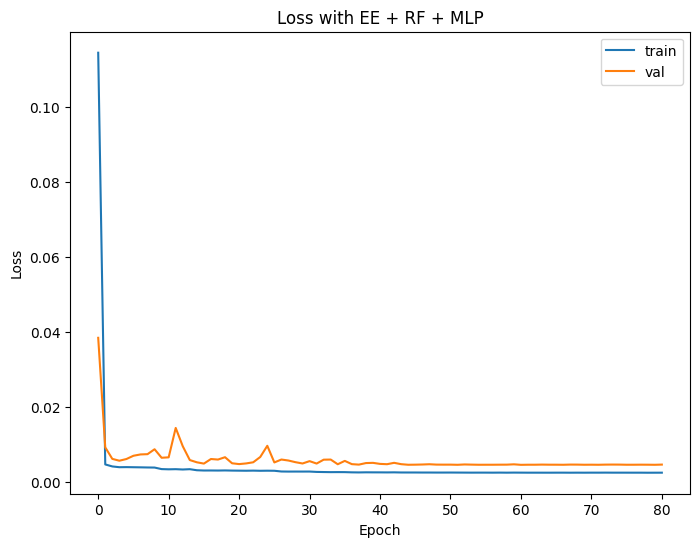

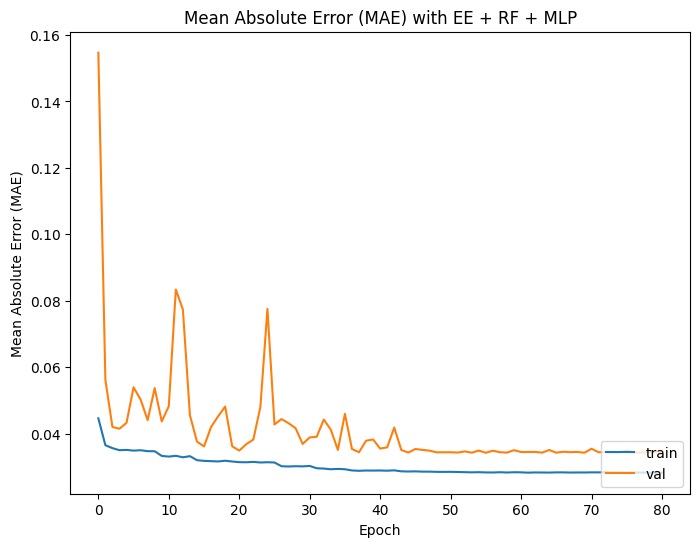

In [14]:
input_brand = Input(shape=(1,), name='input_brand')
emb_brand = Embedding(input_dim=n_unique_brand, output_dim=8)(input_brand)
emb_brand = Reshape(target_shape=(8,))(emb_brand)

input_model = Input(shape=(1,), name='input_model')
emb_model = Embedding(input_dim=n_unique_model, output_dim=15)(input_model)
emb_model = Reshape(target_shape=(15,))(emb_model)

input_vehicleType = Input(shape=(1,), name='input_vehicleType')
emb_vehicleType = Embedding(input_dim=n_unique_vehicleType, output_dim=5)(input_vehicleType)
emb_vehicleType = Reshape(target_shape=(5,))(emb_vehicleType)

input_fuelType = Input(shape=(1,), name='input_fuelType')
emb_fuelType = Embedding(input_dim=n_unique_fuelType, output_dim=4)(input_fuelType)
emb_fuelType = Reshape(target_shape=(4,))(emb_fuelType)

input_numeric = Input(shape=(len(numeric_cols),), name='input_numeric')
emb_numeric = input_numeric

input_rf = Input(shape=(1,), name='input_rf')
input_data = [input_brand, input_model, input_vehicleType, input_fuelType, input_numeric, input_rf]
emb_data = [emb_brand, emb_model, emb_vehicleType, emb_fuelType, emb_numeric, input_rf]

model_data = Concatenate()(emb_data)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(model_data)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.005))(x)
outputs = Dense(1, activation='sigmoid')(x)

ee_rf_mlp = Model(inputs=input_data, outputs=outputs, name='EE_RF_MLP')
ee_rf_mlp.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.002), metrics=['mae'])

# Update input lists with RF predictions
input_list_train_new_rf = input_list_train_new + [rf_train_preds]
input_list_val_rf = input_list_val + [rf_val_preds]
input_list_test_rf = input_list_test + [rf_test_preds]

history_ee_rf_mlp = ee_rf_mlp.fit(
    input_list_train_new_rf,
    y_train_new,
    validation_data=(input_list_val_rf, y_val),
    epochs=150,
    batch_size=512,
    verbose=1,
    callbacks=[es, lr_scheduler]
)

# Plot training history for EE+RF+MLP
plt.figure(figsize=(8, 6))
plt.plot(history_ee_rf_mlp.history['loss'], label='Training Loss')
plt.plot(history_ee_rf_mlp.history['val_loss'], label='Validation Loss')
plt.title('Loss with EE + RF + MLP')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history_ee_rf_mlp.history['mae'], label='Training MAE')
plt.plot(history_ee_rf_mlp.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) with EE + RF + MLP')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Cell 10: Evaluation

2255/2255 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluation Metrics:
              MLP   EE_RF_MLP
MSE     6676638.0   5371115.5
RMSE  2583.919116  2317.56672
R2        0.85707    0.885018
MAPE    45.169781   36.319538


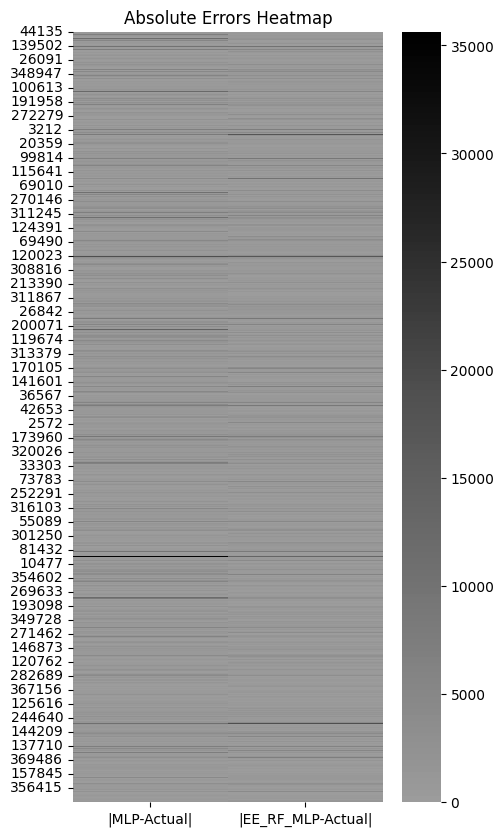

In [16]:
# # Predictions
# y_test_predict_mlp = mlp.predict(input_list_test).flatten()
# y_test_predict_rf = rf.predict(X_test_rf)
# y_test_predict_ee_rf_mlp = ee_rf_mlp.predict(input_list_test_rf).flatten()

# # Inverse transform predictions and actual values
# y_test_predict_mlp = price_scaler.inverse_transform(y_test_predict_mlp.reshape(-1, 1)).flatten()
# y_test_predict_rf = price_scaler.inverse_transform(y_test_predict_rf.reshape(-1, 1)).flatten()
# y_test_predict_ee_rf_mlp = price_scaler.inverse_transform(y_test_predict_ee_rf_mlp.reshape(-1, 1)).flatten()
# y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# # Create results DataFrame
# result_df = pd.DataFrame(index=X_test.index, columns=['Random', 'Naive_Mean', 'MLP', 'RF', 'EE_RF_MLP', 'Actual'])
# result_df['Actual'] = y_test_original
# # result_df['Random'] = price_scaler.inverse_transform(np.random.uniform(y_train.min(), y_train.max(), len(y_test)).reshape(-1, 1)).flatten()
# # result_df['Naive_Mean'] = price_scaler.inverse_transform([[y_train.mean()]] * len(y_test)).flatten()
# result_df['MLP'] = y_test_predict_mlp
# # result_df['RF'] = y_test_predict_rf
# result_df['EE_RF_MLP'] = y_test_predict_ee_rf_mlp

# # Define metric calculation function
# def calculate_metrics(y_true, y_pred):
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_true, y_pred)
#     mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1000))) * 100  # Avoid division by zero
#     return mse, rmse, r2, mape

# # Calculate metrics for all models
# metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'R2', 'MAPE'],
#                         columns=['Random', 'Naive_Mean', 'MLP', 'RF', 'EE_RF_MLP'])

# for model in metric_df.columns:
#     mse, rmse, r2, mape = calculate_metrics(result_df['Actual'], result_df[model])
#     metric_df.at['MSE', model] = mse
#     metric_df.at['RMSE', model] = rmse
#     metric_df.at['R2', model] = r2
#     metric_df.at['MAPE', model] = mape

# print("Evaluation Metrics:")
# print(metric_df)

# # Heatmap of absolute errors
# for m in metric_df.columns:
#     result_df[f'|{m}-Actual|'] = np.abs(result_df[m] - result_df['Actual'])

# table = result_df[[f'|{m}-Actual|' for m in metric_df.columns]]
# plt.figure(figsize=(5, 10))
# sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
# plt.title('Absolute Errors Heatmap')
# plt.show()

# Predictions
y_test_predict_mlp = mlp.predict(input_list_test).flatten()
y_test_predict_rf = rf.predict(X_test_rf)
y_test_predict_ee_rf_mlp = ee_rf_mlp.predict(input_list_test_rf).flatten()

# Inverse transform predictions and actual values
y_test_predict_mlp = price_scaler.inverse_transform(y_test_predict_mlp.reshape(-1, 1)).flatten()
y_test_predict_rf = price_scaler.inverse_transform(y_test_predict_rf.reshape(-1, 1)).flatten()
y_test_predict_ee_rf_mlp = price_scaler.inverse_transform(y_test_predict_ee_rf_mlp.reshape(-1, 1)).flatten()
y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create results DataFrame
result_df = pd.DataFrame(index=X_test.index, columns=['MLP', 'EE_RF_MLP', 'Actual'])
result_df['Actual'] = y_test_original
result_df['MLP'] = y_test_predict_mlp
result_df['EE_RF_MLP'] = y_test_predict_ee_rf_mlp

# Define metric calculation function
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1000))) * 100  # Avoid division by zero
    return mse, rmse, r2, mape

# Calculate metrics for available models
metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'R2', 'MAPE'], columns=result_df.columns.drop('Actual'))

for model in metric_df.columns:
    if result_df[model].isnull().any():  # Skip models with NaN values
        continue
    mse, rmse, r2, mape = calculate_metrics(result_df['Actual'], result_df[model])
    metric_df.at['MSE', model] = mse
    metric_df.at['RMSE', model] = rmse
    metric_df.at['R2', model] = r2
    metric_df.at['MAPE', model] = mape

print("Evaluation Metrics:")
print(metric_df)

# Heatmap of absolute errors
for m in metric_df.columns:
    result_df[f'|{m}-Actual|'] = np.abs(result_df[m] - result_df['Actual'])

table = result_df[[f'|{m}-Actual|' for m in metric_df.columns]]
plt.figure(figsize=(5, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap')
plt.show()
